# Chapter 7 - Which Fit is Fitter

This notebook contains notes of Chapter 7 of [Hauer - The Art of Regression Modelling in Road Safety](https://www.springer.com/gp/book/9783319125282).

In [1]:
# Preamble.
import os
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Default mpl colours.
prop_cycle = plt.rcParams['axes.prop_cycle']
mpl_def_colors = prop_cycle.by_key()['color']

## Goodness of Fit

For safety performance function (SPF) modelling, we cannot simply rely on overall goodness-of-fit metrics like $\chi^2$, we need to confirm that fits are good for all values of all variables. For example, the fit below has obvious bias, since we are fitting a quadratic with a linear model.

In [133]:
np.random.seed(519865498)
xvals = np.linspace(0, 3, 1000)
yvals = 0.5 * xvals**2 + 0.1 * xvals + np.random.normal(scale=0.3, size=1000)
badfit = np.polyfit(xvals, yvals, 1)
yfit = badfit[0] * xvals + badfit[1]

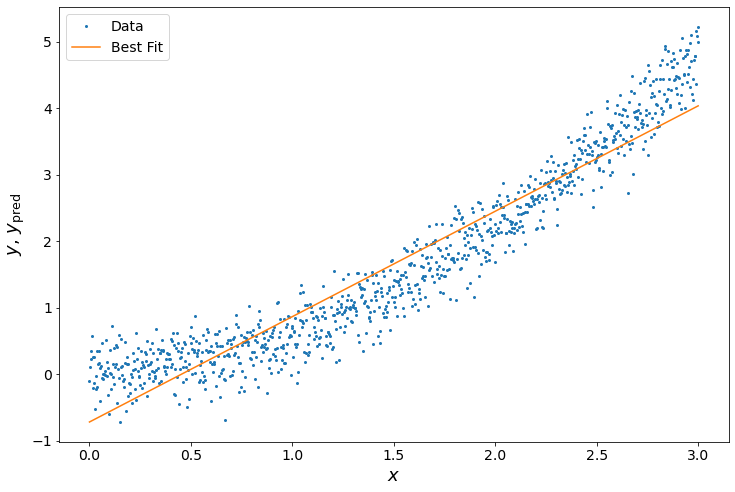

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(xvals, yvals, marker='o', ls="none", ms=2, label="Data")
ax.plot(xvals, yfit, label="Best Fit")
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$y$, $y_\mathrm{pred}$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2, fontsize=14);

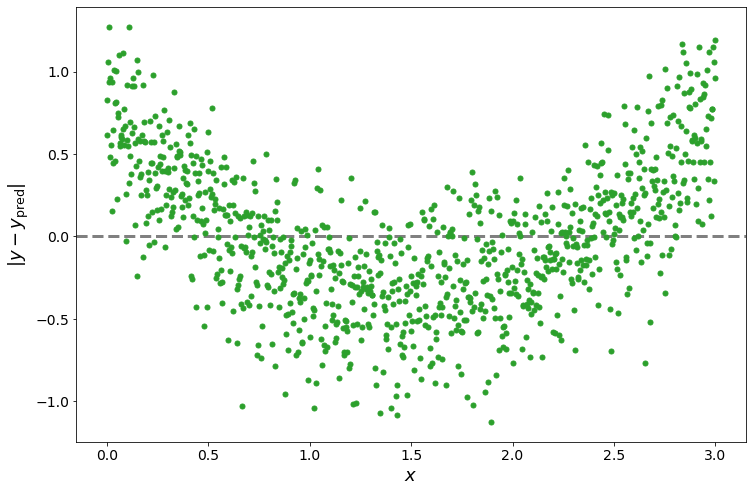

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=0, ls="dashed", lw=3, color="gray")
ax.plot(xvals, (yvals - yfit), marker='o', color=mpl_def_colors[2],
        ls="none", ms=5, label="Residuals")
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$|y - y_\mathrm{pred}|$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14);

The overall goodness of fit measure is comparable to an unbiased fit to data with more variance, but the fit is obviously biased. Hauer says

> In SPF development the main figure of merit is the absence of bias for all variable values for which the model is likely to be used.

*Charles: if we simply checked with a holdout dataset we also wouldn't be able to distinguish between our fit being biased vs. the data having high variance. Only by fitting against a more complex model could we confirm that our fit is bias-dominated.*

The above plot - simply plotting $y_\mathrm{obs} - y_\mathrm{pred}$ is typical way of plotting **residuals vs. some independent variable**.

We shall see shortly, however, that this simple method works poorly for count variable regression.

First, let's generate a synthetic dataset with four exogenous variables:

In [89]:
n_obs = 10000
alpha = 6.5
const = 0.
beta_1 = 0.6
beta_2 = -0.7
beta_3 = 0.6
beta_4 = 1.3

var_def = pd.DataFrame(
    ([beta_1, (0., 5.)],
     [beta_2, (0., 5.)],
     [beta_3, (0., 1.)],
     [beta_4, (0., 2.5)]),
    columns=['beta', 'exog_lim'],
    index=['apples', 'bears', 'candy', 'daisies'])

var_def

,beta,exog_lim
apples,0.6,"(0.0, 5.0)"
bears,-0.7,"(0.0, 5.0)"
candy,0.6,"(0.0, 1.0)"
daisies,1.3,"(0.0, 2.5)"


In [128]:
np.random.seed(854986)

df_exog = pd.DataFrame([], index=np.arange(n_obs, dtype=int))

for var_name, var_row in var_def.iterrows():
    df_exog[var_name] = np.random.uniform(
        low=var_row['exog_lim'][0], high=var_row['exog_lim'][1],
        size=(n_obs,))

lambda_expected = np.exp(df_exog.dot(var_def['beta']) + const)
gamma_draws = np.random.gamma(1. / alpha, alpha, size=n_obs)
endog = np.random.poisson(lam=(lambda_expected * gamma_draws))

model = sm.NegativeBinomial(
    endog=endog, exog=sm.add_constant(df_exog))
results = model.fit(maxiter=100, disp=False)

In [129]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:               NegativeBinomial   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Aug 2020   Pseudo R-squ.:                 0.06215
Time:                        16:23:50   Log-Likelihood:                -21496.
converged:                       True   LL-Null:                       -22921.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0805      0.095      0.846      0.398      -0.106       0.267
apples         0.5851      0.018     31.645      0.000       0.549       0.621
bears         -0.6943      0.018    -37.556      0.000      -0.731      -0.658
candy          0.3425      0.092      3.735      0.000       0.163       0.522
daisies        1.3257      0.037     35.929      0.000       1.253       1.398
alpha          6.4633      0.123     52.528      0.000       6.222       6.704
==============================================================================
"""

That's a reasonable fit.

Let's now plot the residual $y_\mathrm{obs} - y_\mathrm{pred}$ against one of the independent variables (say `apples`).

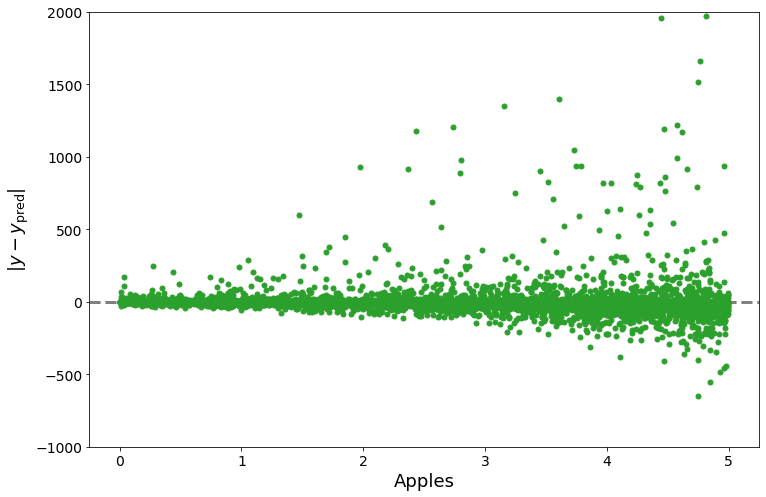

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=0, ls="dashed", lw=3, color="gray")
ax.plot(df_exog['apples'], endog - results.predict(), marker='o', color=mpl_def_colors[2],
        ls="none", ms=5, label="Residuals")
ax.set_xlabel(r'Apples', fontsize=18)
ax.set_ylabel(r'$|y - y_\mathrm{pred}|$', fontsize=18)
ax.set_ylim([-1000, 2000])
ax.tick_params(axis='both', which='major', labelsize=14);

Is this a good residual? Due to the nature of negative binomial regression, simply plotting the residual doesn't yield the same information as a typical gaussian regression.

## CURE Plots

Cumulative residual, or "CURE" plots are generated using this procedure:

1. Sort the data by something (the example Hauer uses is an SPF as the y-variable, and road length as the x).
2. Calculate the residual between the observed and fitted data.
3. Do a cumulative sum of the residual ordered by the x-variable (road length in his example).
4. Plot the cumulative sum, and look for offsets and inflection points.

In [131]:
# Zip up and sort

def get_cureplot_data(x, y):
    cure_rawdata = np.array(sorted(zip(x, y), key=lambda a: a[0]))
    return cure_rawdata[:, 0], np.cumsum(cure_rawdata[:, 1])

cureplot_data = get_cureplot_data(df_exog['apples'], endog - results.predict())

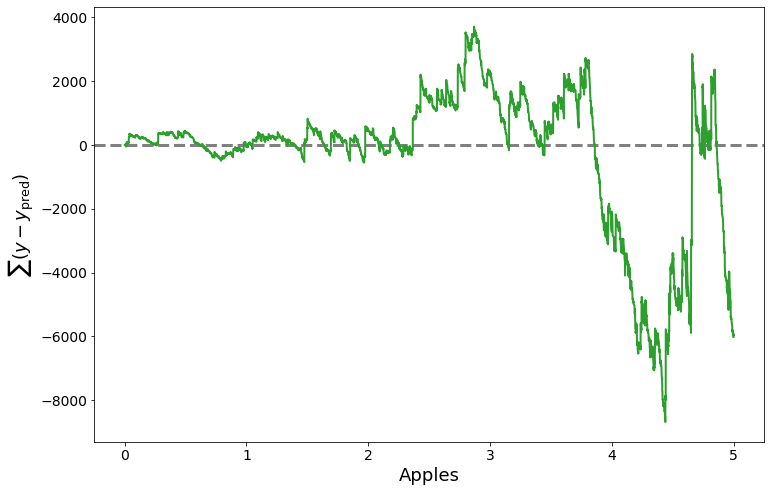

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=0, ls="dashed", lw=3, color="gray")
ax.plot(cureplot_data[0], cureplot_data[1], color=mpl_def_colors[2], ls="solid", lw=2, label="Residuals")
ax.set_xlabel(r'Apples', fontsize=18)
ax.set_ylabel(r'$\sum\left(y - y_\mathrm{pred}\right)$', fontsize=18)
#ax.set_ylim([-1000, 2000])
ax.tick_params(axis='both', which='major', labelsize=14);

To read a CURE plot:

- Locations where the cumulative residual steadily increases are locations where the residual is biased toward the positive: the model tends to underpredict values.
- Locations where the cumulative residual steadily decreases are locations where the model overestimates.
- Very large jumps are possibly outliers, since they represent single points of extremely large residuals.
- Ideally, the CURE plot will bounce back and forth above and below the horizontal axis, consistent with a quasi-symmetric random walk. *Charles: this is because when the fit is good we expect a regression to the mean - the sums of a whole bunch of residuals should sum up to zero.*

When making CURE plots of multivariate models, we simply sort the dependent variable with respect to the independent variable we're interested in.

We can also produce a fitted-value cure plot, by plotting the cumulative residual against the sorted predicted values.

But how should we interpret the large deviation around `apples > 4`? Since the cumulative residual is a random walk (because each residual is a random variable, and we're summing them), shouldn't there be some natural tendency to move off of the horizontal axis? We'll see below.

## The Bias-in-Fit

We can use long stretches of increasing or decreasing cumulative residual to mark down stretches of independent variable where the dependent variable is under or over-predicted.


## When is a CURE Plot Good Enough?

Random walks have a natural tendency to drift, and even given a near-perfect fit with a simple model, we expect the CURE plot to contain some deviation from the horizontal axis.

*Charles: for example, here's a simple, one-variable Poisson.*

In [163]:
np.random.seed(215896859)

xvals = np.linspace(0, 3, 100000)
yvals = np.random.poisson(lam=np.exp(xvals))

# A perfect fit would find lambda = x.
cureplot_data = get_cureplot_data(xvals, yvals - np.exp(xvals))

In [164]:
model = sm.Poisson(
    endog=yvals, exog=xvals)
results = model.fit(maxiter=100, disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:               100000
Model:                        Poisson   Df Residuals:                    99999
Method:                           MLE   Df Model:                            0
Date:                Tue, 11 Aug 2020   Pseudo R-squ.:                  0.4789
Time:                        17:51:03   Log-Likelihood:            -2.1305e+05
converged:                       True   LL-Null:                   -4.0881e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0003      0.001   1812.378      0.000       0.999       1.001
==============================================================================
"""

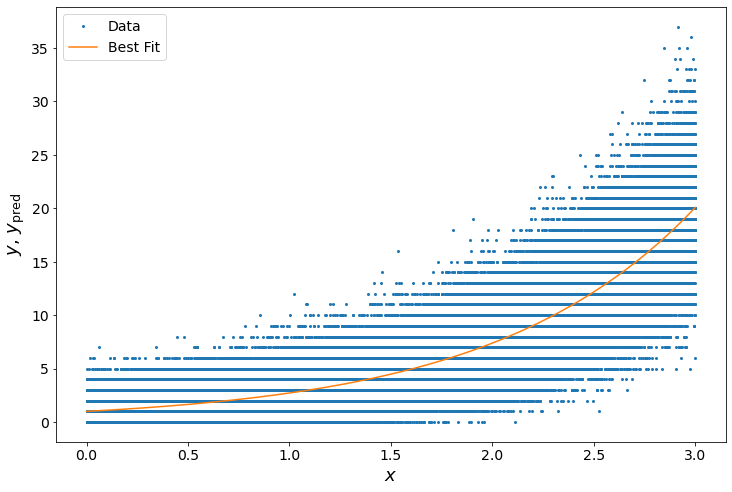

In [165]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(xvals, yvals, marker='o', ls="none", ms=2, label="Data")
ax.plot(xvals, np.exp(xvals), label="Best Fit")
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$y$, $y_\mathrm{pred}$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2, fontsize=14);

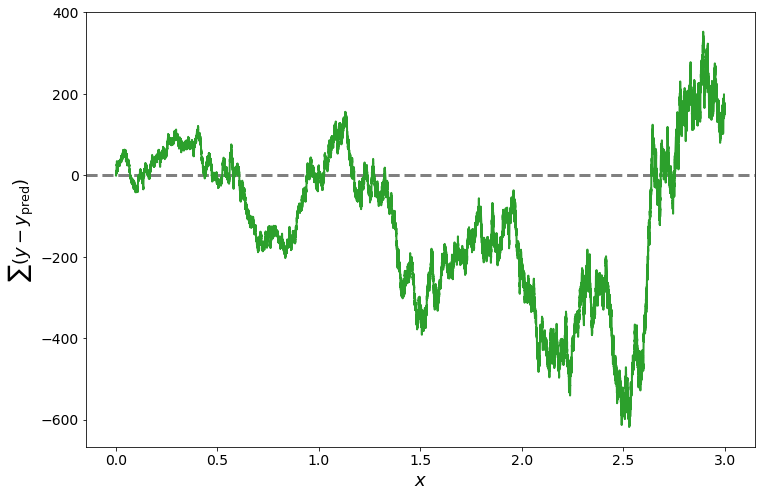

In [166]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=0, ls="dashed", lw=3, color="gray")
ax.plot(cureplot_data[0], cureplot_data[1], color=mpl_def_colors[2], ls="solid", lw=2, label="Residuals")
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$\sum\left(y - y_\mathrm{pred}\right)$', fontsize=18)
#ax.set_ylim([-1000, 2000])
ax.tick_params(axis='both', which='major', labelsize=14);

To estimate $S(i)$ the cumulative sum of the first $i$ residuals, let's assume that the model is the exact generative model for the data, so $E[S(i)] = 0$ (since the expected residual for each data point is zero). Then we can estimate $\sigma_S^2(i)$ by using the sum of squared residuals up to $i$.

*Charles: for a white-noise random walk (each step is IID normal with some variance $\sigma$) of $i$ steps, the variance is $i \sigma_\mathrm{1step}$. Since the variance increases with $x$, a good estimator for the variance at step $i$ is the sum of square residuals.*

From Hauer, Appendix I, even if individual residuals don't have the same variance, we can loosely invoke the central limit theory to justify that $S(i)$ is normally distributed with a mean of 0 and a standard deviation of $\sigma_S(i)$. If we've further constrained our best fit to ensure $\sum y = \sum y_\mathrm{pred}$ (to eg. constrain the total number of collisions to be the same), then the sum of the residuals for the remainder of the residuals from $i$ to $n$ also has mean 0 and standard deviation $\sqrt{\sigma_S^2(n) - \sigma_S^2(i)}$ (equivalent to sum of squared residuals from $i$ to $n$). So, for a random walk that starts and ends at 0, and is equal to $s$ at point $i$, we multiply the two normals together to get the probability distribution for $S(i) = s$.

Thus, we can design a 1-sigma envelope showing the maximum expected extent of the CURE plot at any given point by drawing lines at

$$
\sigma'_s(i) = \pm \sigma_S(i)\sqrt{1 - \frac{\sigma_S^2(i)}{\sigma_S^2(n)}}
$$

In [167]:
def get_cureplot_data(x, y):
    cure_rawdata = np.array(sorted(zip(x, y), key=lambda a: a[0]))
    cure_x = cure_rawdata[:, 0]
    cure_y = np.cumsum(cure_rawdata[:, 1])
    cure_sig_i = np.sqrt(np.cumsum(cure_rawdata[:, 1]**2))
    cure_sig_i_constrained = cure_sig_i * np.sqrt(1 - (cure_sig_i**2 / cure_sig_i[-1]**2))
    return cure_x, cure_y, cure_sig_i, cure_sig_i_constrained

In [168]:
cureplot_data = get_cureplot_data(xvals, yvals - np.exp(xvals))

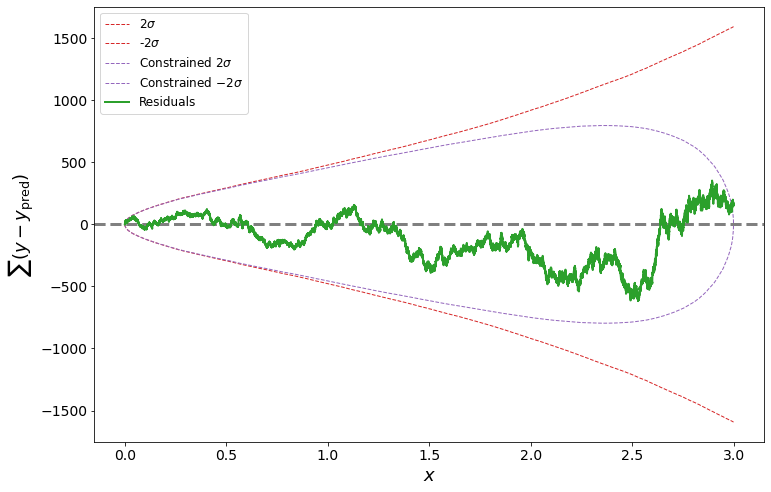

In [174]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(y=0, ls="dashed", lw=3, color="gray")
ax.plot(cureplot_data[0], 2 * cureplot_data[2], color=mpl_def_colors[3], ls="dashed", lw=1, label=r"$2\sigma$")
ax.plot(cureplot_data[0], -2 * cureplot_data[2], color=mpl_def_colors[3], ls="dashed", lw=1, label="-$2\sigma$")
ax.plot(cureplot_data[0], 2 * cureplot_data[3], color=mpl_def_colors[4], ls="dashed", lw=1, label=r"Constrained $2\sigma$")
ax.plot(cureplot_data[0], -2 * cureplot_data[3], color=mpl_def_colors[4], ls="dashed", lw=1, label=r"Constrained $-2\sigma$")
ax.plot(cureplot_data[0], cureplot_data[1], color=mpl_def_colors[2], ls="solid", lw=2, label="Residuals")
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$\sum\left(y - y_\mathrm{pred}\right)$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2, fontsize=12);

Hauer notes that if we see the random walk fall well below even $\pm 0.5\sigma$, we may be in danger of **overfitting**.

## Comparing CURE Plots

We can compare two CURE plots based on their **slopes**, not their proximity to the x-axis. Thus, if one CURE plot is simply the offset version of another, the two have similar bias-in-fit problems.

## Experiments

*Charles: I experimented with generating CURE plots from negative binomial fits.*